In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df = pd.read_csv('../../data/DATASET_FINAL_DIVORCIOS.csv')
df.head()


,Departamento,Divorcios,Denuncias,Sexo_Hombre,Sexo_Mujer,0 a 4,5 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado_edad
0,República,"91,536","484,607","52,835","431,772",530,"1,015","3,359","39,506","87,672","90,822","79,107","59,870","40,395","25,711","16,870","10,963","7,898","14,401","6,488"
1,Guatemala,"35,192","90,889","9,909","80,980",99,190,630,"7,409","16,443","17,034","14,837","11,229","7,576","4,822","3,164","2,056","1,481","2,701","1,217"
2,El Progreso,"1,577","15,295","1,668","13,627",17,32,106,"1,247","2,767","2,866","2,497","1,890","1,275",811,532,346,249,455,205
3,Sacatepéquez,"1,968","22,713","2,476","20,237",25,48,157,"1,852","4,109","4,257","3,708","2,806","1,893","1,205",791,514,370,675,304
4,Chimaltenango,"1,801","26,664","2,907","23,757",29,56,185,"2,174","4,824","4,997","4,353","3,294","2,223","1,415",928,603,435,792,357


# Limpieza de datos

In [19]:
# Eliminar filas de totales nacionales si existen
df = df[df['Departamento'] != 'República']

# Reemplazar comas por nada y convertir a entero
cols_numericas = df.columns.drop('Departamento')
df[cols_numericas] = df[cols_numericas].replace(',', '', regex=True).astype(int)

# Crear la variable objetivo: "Categoria_Divorcios"
promedio_nacional = df['Denuncias'].mean()
df['Categoria_Denuncias'] = df['Denuncias'].apply(
    lambda x: 'alto' if x > promedio_nacional else ('bajo' if x < promedio_nacional else 'neutro')
)

In [21]:
# Verificar valores únicos
df['Categoria_Denuncias'].value_counts()

Categoria_Denuncias
bajo    15
alto     8
Name: count, dtype: int64

In [22]:
df.head()

,Departamento,Divorcios,Denuncias,Sexo_Hombre,Sexo_Mujer,0 a 4,5 a 9,10 a 14,15 a 19,20 a 24,...,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado_edad,Categoria_Denuncias
1,Guatemala,35192,90889,9909,80980,99,190,630,7409,16443,...,14837,11229,7576,4822,3164,2056,1481,2701,1217,alto
2,El Progreso,1577,15295,1668,13627,17,32,106,1247,2767,...,2497,1890,1275,811,532,346,249,455,205,bajo
3,Sacatepéquez,1968,22713,2476,20237,25,48,157,1852,4109,...,3708,2806,1893,1205,791,514,370,675,304,alto
4,Chimaltenango,1801,26664,2907,23757,29,56,185,2174,4824,...,4353,3294,2223,1415,928,603,435,792,357,alto
5,Escuintla,4131,15404,1679,13725,17,32,107,1256,2787,...,2515,1903,1284,817,536,348,251,458,206,bajo


# Visualizacion de datos

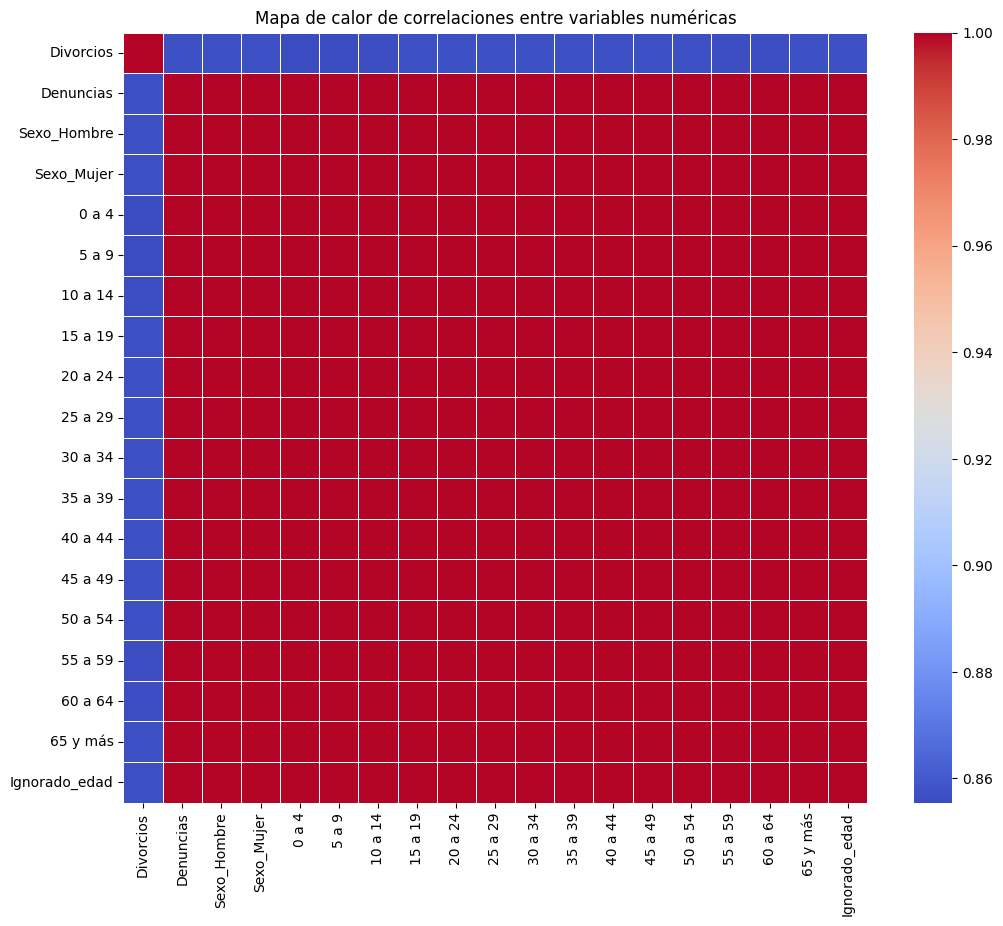

In [23]:
# Visualización: Mapa de calor de correlaciones
correlation_matrix = df[cols_numericas].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Mapa de calor de correlaciones entre variables numéricas")
plt.show()

Este análisis revela una alta colinealidad entre los grupos etarios y otras variables poblacionales, lo cual es esperado

# Modelo SVM

## Buscar el mejor modelo

In [24]:
# Variables X e y
X = df.drop(columns=['Departamento', 'Categoria_Denuncias', 'Denuncias'])  # No usamos Denuncias porque define la etiqueta
y = df['Categoria_Denuncias']

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificación de la clase
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)


In [25]:
from sklearn.model_selection import GridSearchCV

modelo = SVC()
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.01, 0.1, 1, 5, 16, 32],
    'gamma': ['scale', 'auto'],  
    'degree': [2, 3, 4],          
    'decision_function_shape': ['ovo', 'ovr']
}

grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_accuracy = grid_search.score(X_test, y_test)
best_params = grid_search.best_params_

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_sorted = cv_results.sort_values("mean_test_score", ascending=False)

mejor_linear = cv_results_sorted[cv_results_sorted['param_kernel'] == 'linear'].iloc[0]
mejor_rbf = cv_results_sorted[cv_results_sorted['param_kernel'] == 'rbf'].iloc[0]
mejor_poly = cv_results_sorted[cv_results_sorted['param_kernel'] == 'poly'].iloc[0]

print("Mejor modelo LINEAR:")
print("Parámetros:", mejor_linear['params'])
print("Accuracy promedio:", mejor_linear['mean_test_score'])

print("\nMejor modelo RBF:")
print("Parámetros:", mejor_rbf['params'])
print("Accuracy promedio:", mejor_rbf['mean_test_score'])

print("\nMejor modelo POLY:")
print("Parámetros:", mejor_poly['params'])
print("Accuracy promedio:", mejor_poly['mean_test_score'])

Mejor modelo LINEAR:
Parámetros: {'C': 1, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Accuracy promedio: 1.0

Mejor modelo RBF:
Parámetros: {'C': 5, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy promedio: 1.0

Mejor modelo POLY:
Parámetros: {'C': 0.01, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy promedio: 0.7333333333333332


## Modelo Linear con parametros dados


In [26]:
svm_model = SVC(
    kernel='linear',
    C=1,
    gamma='auto',
    degree=2,
    decision_function_shape='ovo',
    class_weight='balanced'
)


### Entrenamiento con validacion cruzada

In [27]:
# Validación cruzada estratificada 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_scaled, y_encoded, cv=cv, scoring='accuracy')

# Promedio y desviación estándar
scores_mean = np.mean(scores)
scores_std = np.std(scores)

print("Accuracies por fold:", scores)
print("Promedio:", scores_mean)
print("Desviación estándar:", scores_std)

Accuracies por fold: [1.  1.  0.8 1.  1. ]
Promedio: 0.96
Desviación estándar: 0.07999999999999999


### Evaluacion de modelo con matriz de confusion

Accuracy: 1.0
Reporte de clasificación:
               precision    recall  f1-score   support

        alto       1.00      1.00      1.00         2
        bajo       1.00      1.00      1.00         5

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



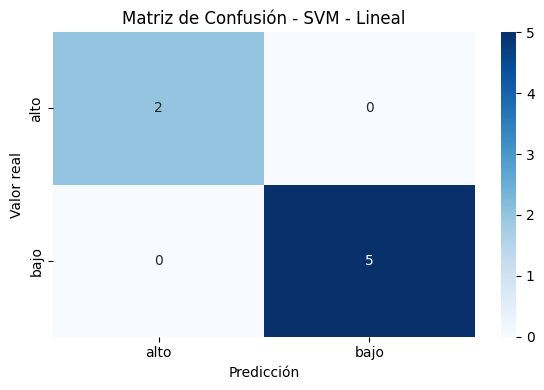

In [28]:
svm_model.fit(X_train, y_train)

# Predicción y métricas
y_pred = svm_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Reporte de clasificación:\n", report)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - SVM - Lineal")
plt.tight_layout()
plt.show()


## Modelo gaussiano con parametros dados

In [29]:
svm_model_rbf = SVC(
    kernel='rbf',
    C=5,
    gamma='auto',
    degree=3,
    decision_function_shape='ovr',
    class_weight='balanced'
)


### Entrenamiento con validacion cruzada

In [30]:
# Validación cruzada estratificada 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model_rbf, X_scaled, y_encoded, cv=cv, scoring='accuracy')

# Promedio y desviación estándar
scores_mean = np.mean(scores)
scores_std = np.std(scores)

print("Accuracies por fold:", scores)
print("Promedio:", scores_mean)
print("Desviación estándar:", scores_std)

Accuracies por fold: [1. 1. 1. 1. 1.]
Promedio: 1.0
Desviación estándar: 0.0


### Evaluacion de modelo con matriz de confusion

Accuracy: 1.0
Reporte de clasificación:
               precision    recall  f1-score   support

        alto       1.00      1.00      1.00         2
        bajo       1.00      1.00      1.00         5

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



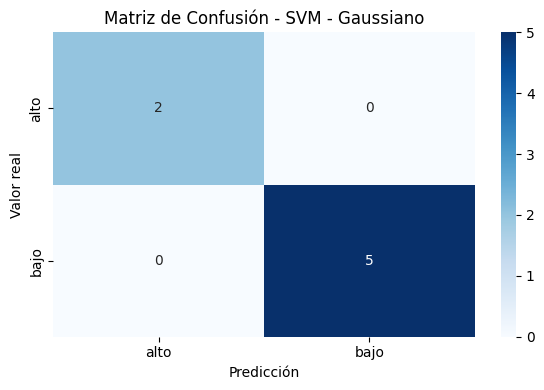

In [31]:
svm_model_rbf.fit(X_train, y_train)

# Predicción y métricas
y_pred = svm_model_rbf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Reporte de clasificación:\n", report)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - SVM - Gaussiano")
plt.tight_layout()
plt.show()


## Modelo Polinomial con parametros dados

In [32]:
svm_model_poly = SVC(
    kernel='poly',
    C=0.01,
    gamma='scale',
    degree=3,
    decision_function_shape='ovo',
    class_weight='balanced'
)


### Entrenamiento con validacion cruzada

In [33]:
# Validación cruzada estratificada 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model_poly, X_scaled, y_encoded, cv=cv, scoring='accuracy')

# Promedio y desviación estándar
scores_mean = np.mean(scores)
scores_std = np.std(scores)

print("Accuracies por fold:", scores)
print("Promedio:", scores_mean)
print("Desviación estándar:", scores_std)

Accuracies por fold: [0.8  0.6  0.6  0.75 0.75]
Promedio: 0.7
Desviación estándar: 0.08366600265340757


### Evaluacion de modelo con matriz de confusion

c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Accuracy: 0.7142857142857143
Reporte de clasificación:
               precision    recall  f1-score   support

        alto       0.00      0.00      0.00         2
        bajo       0.71      1.00      0.83         5

    accuracy                           0.71         7
   macro avg       0.36      0.50      0.42         7
weighted avg       0.51      0.71      0.60         7



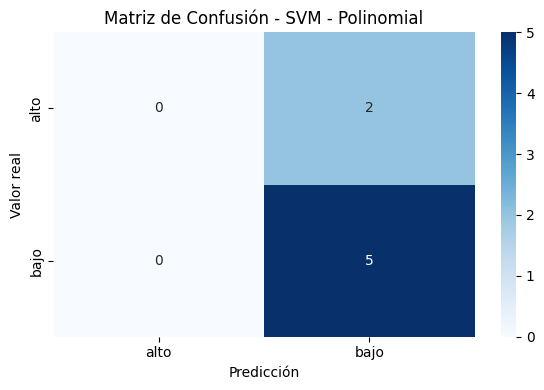

In [34]:
svm_model_poly.fit(X_train, y_train)

# Predicción y métricas
y_pred = svm_model_poly.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Reporte de clasificación:\n", report)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - SVM - Polinomial")
plt.tight_layout()
plt.show()


# Analisis de resultados

#### SVM Lineal
- Clasifica correctamente todos los casos.
- Tiene 100% de precisión y recall en ambas clases.
- Muestra que una frontera lineal es suficiente para separar los datos en este caso.

#### SVM RBF (Gaussiano)
- Igual que el lineal, logra perfecta separación entre las clases.
- También alcanza 100% en todas las métricas.

#### SVM Polinomial
- Falla completamente en clasificar la clase "alto" (100% de falsos negativos).
- Aunque clasifica todos los casos de "bajo" correctamente, tiene un desempeño sesgado y pobre en clasificación general (accuracy de 71%).

# Conclusiones

- SVM Lineal y RBF son igualmente efectivos y excelentes para este conjunto de datos en su estado actual. Ambos logran separación perfecta.
- SVM Polinomial es una mala elección aquí: sobreajusta o define una frontera no adecuada, lo que causa pérdida total en la clase minoritaria.
- Esto sugiere que los datos tienen una separabilidad sencilla, y un modelo más complejo como el polinomial empeora el rendimiento.